In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"srilayav","key":"28c2027b05c9256d7273f7b5d4e9e553"}'}

In [3]:
!mkdir ~/.kaggle/

In [4]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c dogs-vs-cats

 97% 790M/812M [00:02<00:00, 258MB/s]
100% 812M/812M [00:02<00:00, 290MB/s]


In [6]:
!unzip -qq dogs-vs-cats.zip

In [7]:
!unzip -qq train.zip

In [8]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_1")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [10]:

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

In [11]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

It can be observed that,model might overfit,thus,we use regularization technique in the stage of DATA PREPROCESSING.
Here,all the images are converted to tensors.

In [12]:

from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


callback can be used to save the model's weights after every epoch or to stop training early if the model is not improving. Additionally, callbacks can be used to log metrics, visualize the model's performance, or schedule learning rate changes.

In [13]:
from tensorflow import keras
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch1.x",
        save_best_only=True,
        monitor="val_loss"
    )
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 20s 115ms/step - loss: 0.7166 - accuracy: 0.5165 - val_loss: 0.6892 - val_accuracy: 0.6160
Epoch 2/10
63/63 [==============================] - 6s 91ms/step - loss: 0.6976 - accuracy: 0.5375 - val_loss: 0.6846 - val_accuracy: 0.5850
Epoch 3/10
63/63 [==============================] - 5s 75ms/step - loss: 0.6846 - accuracy: 0.5840 - val_loss: 0.6516 - val_accuracy: 0.6540
Epoch 4/10
63/63 [==============================] - 5s 76ms/step - loss: 0.6625 - accuracy: 0.6210 - val_loss: 0.6531 - val_accuracy: 0.5820
Epoch 5/10
63/63 [==============================] - 5s 75ms/step - loss: 0.6176 - accuracy: 0.6550 - val_loss: 0.6076 - val_accuracy: 0.6670
Epoch 6/10
63/63 [==============================] - 6s 84ms/step - loss: 0.5984 - accuracy: 0.6745 - val_loss: 0.6072 - val_accuracy: 0.6430
Epoch 7/10
63/63 [==============================] - 4s 60ms/step - loss: 0.5650 - accuracy: 0.6970 - val_loss: 0.6252 - val_accuracy: 0.6440
Epoch 8/10


It can be shown that as the number of epochs increases, accuracy increases.

Accuracy=77.2% Val_acc=67.7% test accuracy=63.6%

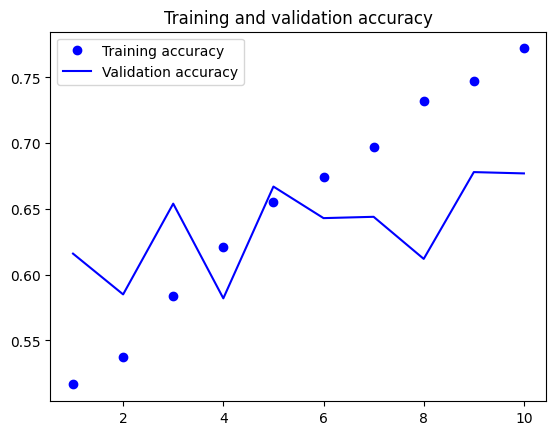

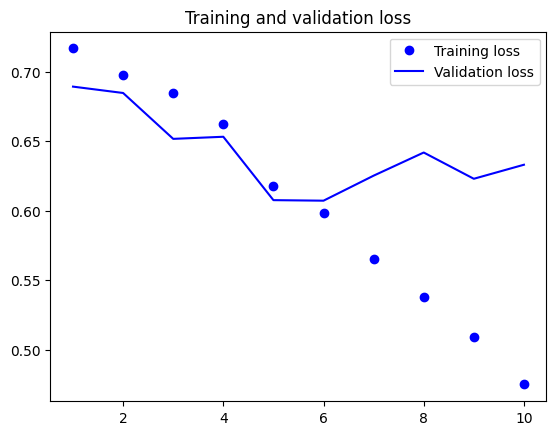

In [14]:

import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [15]:

test_model = keras.models.load_model("convnet_from_scratch1.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 30ms/step - loss: 0.6275 - accuracy: 0.6360
Test accuracy: 0.636


test accuracy without data augmentation=63.6%

**Data Augmentation**

"Data augmentation" makes new, altered versions of the original data in order to expand the size of a training set. This enhances the model's capacity for generalization and reduces overfitting.

In [16]:

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [17]:

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 10s 116ms/step - loss: 0.6970 - accuracy: 0.4905 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 2/10
63/63 [==============================] - 6s 92ms/step - loss: 0.6928 - accuracy: 0.5370 - val_loss: 0.6857 - val_accuracy: 0.6230
Epoch 3/10
63/63 [==============================] - 10s 154ms/step - loss: 0.6880 - accuracy: 0.5545 - val_loss: 0.6653 - val_accuracy: 0.6070
Epoch 4/10
63/63 [==============================] - 7s 110ms/step - loss: 0.6657 - accuracy: 0.6025 - val_loss: 0.6562 - val_accuracy: 0.6090
Epoch 5/10
63/63 [==============================] - 6s 90ms/step - loss: 0.6545 - accuracy: 0.6085 - val_loss: 0.6274 - val_accuracy: 0.6360
Epoch 6/10
63/63 [==============================] - 5s 79ms/step - loss: 0.6201 - accuracy: 0.6540 - val_loss: 0.6643 - val_accuracy: 0.5790
Epoch 7/10
63/63 [==============================] - 4s 61ms/step - loss: 0.6145 - accuracy: 0.6550 - val_loss: 0.6526 - val_accuracy: 0.6440
Epoch 8/

Data augmentation to the model did not produce improved results, however this can be tested by increasing the training sample size and experimenting with data augmentation on it.

accuracy=68.5% val_acc=71.8% test_acc=69.7%

In [22]:

test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 32ms/step - loss: 0.5706 - accuracy: 0.6970
Test accuracy: 0.697


**2)Increase training sample size**

Tried by increasing training sample size from 1000 to 1500.



In [23]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

In [24]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [25]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [27]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch2.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
94/94 [==============================] - 7s 76ms/step - loss: 0.6940 - accuracy: 0.5437 - val_loss: 0.6970 - val_accuracy: 0.5310
Epoch 2/10
94/94 [==============================] - 6s 63ms/step - loss: 0.6781 - accuracy: 0.5953 - val_loss: 0.6302 - val_accuracy: 0.6380
Epoch 3/10
94/94 [==============================] - 6s 66ms/step - loss: 0.6238 - accuracy: 0.6563 - val_loss: 0.6342 - val_accuracy: 0.6450
Epoch 4/10
94/94 [==============================] - 7s 69ms/step - loss: 0.5941 - accuracy: 0.6837 - val_loss: 0.5949 - val_accuracy: 0.6870
Epoch 5/10
94/94 [==============================] - 7s 76ms/step - loss: 0.5683 - accuracy: 0.7153 - val_loss: 0.5659 - val_accuracy: 0.7000
Epoch 6/10
94/94 [==============================] - 5s 53ms/step - loss: 0.5245 - accuracy: 0.7327 - val_loss: 0.6197 - val_accuracy: 0.6960
Epoch 7/10
94/94 [==============================] - 7s 67ms/step - loss: 0.4842 - accuracy: 0.7650 - val_loss: 0.7530 - val_accuracy: 0.6170
Epoch 8/10
94

In [29]:
test_model = keras.models.load_model(
    "convnet_from_scratch2.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 31ms/step - loss: 0.5207 - accuracy: 0.7460
Test accuracy: 0.746


Accuracy=83.7% val_acc=70.9% test_acc=74.6%

**Using data augmentation**

In [30]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [31]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [33]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation2.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/10
94/94 [==============================] - 8s 81ms/step - loss: 0.6934 - accuracy: 0.5037 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/10
94/94 [==============================] - 7s 74ms/step - loss: 0.6927 - accuracy: 0.5057 - val_loss: 0.6872 - val_accuracy: 0.5300
Epoch 3/10
94/94 [==============================] - 7s 68ms/step - loss: 0.6905 - accuracy: 0.5127 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 4/10
94/94 [==============================] - 5s 55ms/step - loss: 0.6947 - accuracy: 0.5013 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 5/10
94/94 [==============================] - 7s 77ms/step - loss: 0.6933 - accuracy: 0.5060 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/10
94/94 [==============================] - 8s 82ms/step - loss: 0.6935 - accuracy: 0.5070 - val_loss: 0.7116 - val_accuracy: 0.5100
Epoch 7/10
94/94 [==============================] - 6s 62ms/step - loss: 0.6938 - accuracy: 0.4943 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 8/10
94

In [34]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation2.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 30ms/step - loss: 0.6754 - accuracy: 0.5910
Test accuracy: 0.591


Accuracy=53.7% val_acc=57.9% test_acc=59.1%

**3. Finding the ideal training sample size**

We set the training, validation, and test set sizes, respectively, to 1500, 1000, and 500.

In [35]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

In [36]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 3000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [37]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


In [38]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch3.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
94/94 [==============================] - 11s 82ms/step - loss: 0.6940 - accuracy: 0.5220 - val_loss: 0.6876 - val_accuracy: 0.5105
Epoch 2/10
94/94 [==============================] - 8s 87ms/step - loss: 0.6695 - accuracy: 0.6127 - val_loss: 0.6234 - val_accuracy: 0.6695
Epoch 3/10
94/94 [==============================] - 8s 83ms/step - loss: 0.6145 - accuracy: 0.6563 - val_loss: 0.5857 - val_accuracy: 0.6925
Epoch 4/10
94/94 [==============================] - 6s 64ms/step - loss: 0.5800 - accuracy: 0.6963 - val_loss: 0.6518 - val_accuracy: 0.6740
Epoch 5/10
94/94 [==============================] - 7s 75ms/step - loss: 0.5525 - accuracy: 0.7237 - val_loss: 0.8658 - val_accuracy: 0.5820
Epoch 6/10
94/94 [==============================] - 8s 84ms/step - loss: 0.5299 - accuracy: 0.7390 - val_loss: 0.5367 - val_accuracy: 0.7460
Epoch 7/10
94/94 [==============================] - 6s 65ms/step - loss: 0.4823 - accuracy: 0.7657 - val_loss: 0.5847 - val_accuracy: 0.6870
Epoch 8/10
9

In [39]:
test_model = keras.models.load_model(
    "convnet_from_scratch3.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 38ms/step - loss: 0.5724 - accuracy: 0.7100
Test accuracy: 0.710


Accuracy=83.2% val_Acc=75.3% test_Acc=71.0%

**Using Data augmentation**

In [40]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [41]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [42]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation3.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
94/94 [==============================] - 13s 99ms/step - loss: 0.6975 - accuracy: 0.5053 - val_loss: 0.6922 - val_accuracy: 0.5065
Epoch 2/10
94/94 [==============================] - 8s 87ms/step - loss: 0.6871 - accuracy: 0.5333 - val_loss: 0.6869 - val_accuracy: 0.5415
Epoch 3/10
94/94 [==============================] - 9s 94ms/step - loss: 0.6831 - accuracy: 0.5703 - val_loss: 0.6756 - val_accuracy: 0.5560
Epoch 4/10
94/94 [==============================] - 8s 78ms/step - loss: 0.6726 - accuracy: 0.5793 - val_loss: 0.6834 - val_accuracy: 0.5430
Epoch 5/10
94/94 [==============================] - 6s 65ms/step - loss: 0.6563 - accuracy: 0.6133 - val_loss: 0.6834 - val_accuracy: 0.6165
Epoch 6/10
94/94 [==============================] - 8s 83ms/step - loss: 0.6446 - accuracy: 0.6310 - val_loss: 0.6338 - val_accuracy: 0.6500
Epoch 7/10
94/94 [==============================] - 9s 96ms/step - loss: 0.6333 - accuracy: 0.6563 - val_loss: 0.6228 - val_accuracy: 0.6550
Epoch 8/10
9

In [44]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation3.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 30ms/step - loss: 0.5907 - accuracy: 0.7080
Test accuracy: 0.708


Accuracy=68.03% val_acc=69.4% test_acc=70.8%

**4.Using a pre-trained network**

VGG16 is the architecture of this pre-trained network.

Feature extraction - Instantiating the VGG16 convolutional base

In [45]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))
conv_base.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                              

Feature extraction - Extracting features and corresponding labels

In [46]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

train_features.shape

1/1 [==============================] - 1s 1s/step


(3000, 5, 5, 512)

Feature extraction is the process of defining and training a highly connected classifier.

In [48]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extractionPT1.x",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=15,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/15
94/94 [==============================] - 2s 14ms/step - loss: 16.9512 - accuracy: 0.9323 - val_loss: 4.9964 - val_accuracy: 0.9700
Epoch 2/15
94/94 [==============================] - 1s 5ms/step - loss: 3.3682 - accuracy: 0.9777 - val_loss: 10.5702 - val_accuracy: 0.9545
Epoch 3/15
94/94 [==============================] - 1s 10ms/step - loss: 1.4491 - accuracy: 0.9887 - val_loss: 4.5392 - val_accuracy: 0.9755
Epoch 4/15
94/94 [==============================] - 1s 5ms/step - loss: 1.4861 - accuracy: 0.9890 - val_loss: 22.9557 - val_accuracy: 0.9130
Epoch 5/15
94/94 [==============================] - 1s 7ms/step - loss: 1.0902 - accuracy: 0.9910 - val_loss: 4.7731 - val_accuracy: 0.9770
Epoch 6/15
94/94 [==============================] - 1s 5ms/step - loss: 0.3679 - accuracy: 0.9953 - val_loss: 4.9031 - val_accuracy: 0.9785
Epoch 7/15
94/94 [==============================] - 1s 6ms/step - loss: 0.3713 - accuracy: 0.9953 - val_loss: 7.1482 - val_accuracy: 0.9695
Epoch 8/15
94/9

accuracy=99.7% val_acc=97.5%

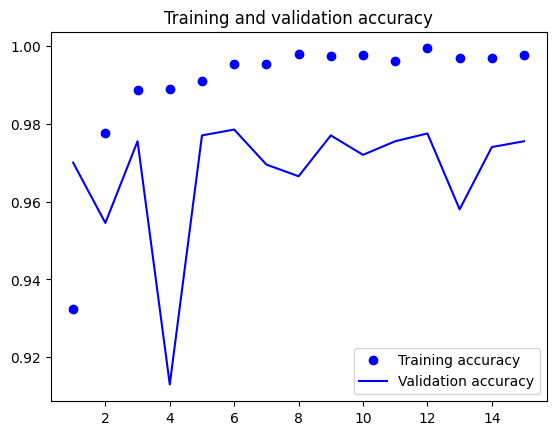

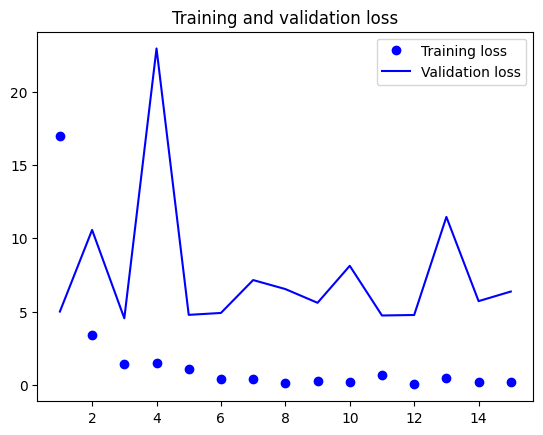

In [49]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [50]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False


conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))


conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


**Feature extraction with Data Augmentation**

In [51]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [52]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentationPT2.x",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/5
94/94 [==============================] - 19s 179ms/step - loss: 14.3148 - accuracy: 0.9103 - val_loss: 4.4176 - val_accuracy: 0.9725
Epoch 2/5
94/94 [==============================] - 17s 182ms/step - loss: 8.0396 - accuracy: 0.9480 - val_loss: 3.6464 - val_accuracy: 0.9780
Epoch 3/5
94/94 [==============================] - 14s 149ms/step - loss: 5.5394 - accuracy: 0.9580 - val_loss: 5.6735 - val_accuracy: 0.9705
Epoch 4/5
94/94 [==============================] - 14s 151ms/step - loss: 5.0941 - accuracy: 0.9593 - val_loss: 4.1036 - val_accuracy: 0.9745
Epoch 5/5
94/94 [==============================] - 14s 149ms/step - loss: 4.6469 - accuracy: 0.9593 - val_loss: 3.8231 - val_accuracy: 0.9730


In [53]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentationPT2.x")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 86ms/step - loss: 4.7596 - accuracy: 0.9700
Test accuracy: 0.970


Accuracy=95.9% val_Acc=97.3% test_acc=97.0%

